In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier as RFC

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv('Datasets/amazon/amazon_review_ID.shuf.lrn.csv')
df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,0,8,6,10,6,7,2,2,2,3,...,1,0,0,0,0,0,0,0,0,Chell
1,1,13,1,13,9,8,8,2,3,2,...,4,1,2,1,0,1,0,0,0,Engineer
2,2,16,7,6,7,9,3,4,2,6,...,0,0,0,0,1,0,0,0,0,Grove
3,3,8,11,10,11,3,7,0,4,2,...,0,0,1,0,0,0,2,1,0,Davisson
4,4,10,11,8,5,3,4,2,5,5,...,0,0,0,0,0,0,0,0,0,Wilson


In [4]:
#scaled_features = StandardScaler().fit_transform(df.loc[:,'V1':'V10000'].values)
#X_train = pd.DataFrame(scaled_features, index=df.loc[:,'V1':'V10000'].index, columns=df.loc[:,'V1':'V10000'].columns)
X_lrn = df.loc[:,'V1':'V10000']
scaled_features = StandardScaler().fit_transform(X_lrn.values)
X_lrn = pd.DataFrame(scaled_features, index=X_lrn.index, columns=X_lrn.columns)

In [5]:
Y_lrn = df.loc[:,'Class':'Class']
Y_lrn

,Class
0,Chell
1,Engineer
2,Grove
3,Davisson
4,Wilson
...,...
745,Riley
746,Neal
747,Messick
748,Mitchell


In [6]:
X_test = pd.read_csv('Datasets/amazon/amazon_review_ID.shuf.tes.csv').drop('ID', axis=1)
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V9991,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000
0,15,10,6,7,9,3,3,3,1,1,...,0,0,1,1,0,0,0,0,0,0
1,8,10,7,2,5,7,2,5,3,3,...,0,4,0,0,0,0,0,2,1,0
2,18,9,7,8,8,7,12,6,7,1,...,0,0,1,0,0,0,1,0,0,1
3,6,5,4,2,4,1,1,1,0,3,...,0,2,0,0,0,0,0,1,0,0
4,9,3,2,5,9,3,0,3,2,4,...,0,0,0,0,0,0,0,1,0,0


# RandomForestClassifier for Amazon Review Dataset


In [68]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_lrn, Y_lrn, test_size=.4)

In [97]:
num_threads = 3
scores = []

for feats in np.linspace(0.1,1,10):
    print("#"*40)
    print("max_features:", feats)
    rf = RFC(n_jobs=num_threads,n_estimators=400, max_features=feats, bootstrap=True, oob_score=True)
    rf.fit(X_train, Y_train)
    print("oob score:", rf.oob_score_)
    rf.get_params()
    Y_pred = rf.predict(X_valid)
    score = accuracy_score(Y_valid, Y_pred)
    print(f"number of validation samples: {X_valid.shape[0]}")
    print(f"accuracy: {score*100:.2f}% --> {accuracy_score(Y_valid, Y_pred, normalize=False)}")
    scores.append(score)
else:
    print("-"*40)

########################################
max_features: 0.1
oob score: 0.5422222222222223
number of validation samples: 300
accuracy: 55.00% --> 165
########################################
max_features: 0.2
oob score: 0.5222222222222223
number of validation samples: 300
accuracy: 53.33% --> 160
########################################
max_features: 0.30000000000000004
oob score: 0.5333333333333333
number of validation samples: 300
accuracy: 53.00% --> 159
########################################
max_features: 0.4
oob score: 0.5511111111111111
number of validation samples: 300
accuracy: 52.33% --> 157
########################################
max_features: 0.5
oob score: 0.5511111111111111
number of validation samples: 300
accuracy: 51.33% --> 154
########################################
max_features: 0.6
oob score: 0.5222222222222223
number of validation samples: 300
accuracy: 50.00% --> 150
########################################
max_features: 0.7000000000000001
oob score: 0.551111111

In [124]:
rf = RFC(n_jobs=num_threads, n_estimators=800, max_features="auto", min_samples_split=2, min_samples_leaf=1, max_depth=40, bootstrap=True, oob_score=True)
rf.fit(X_train, Y_train)
print("oob score:", rf.oob_score_)
rf.get_params()
Y_pred = rf.predict(X_valid)
score = accuracy_score(Y_valid, Y_pred)
print(f"number of validation samples: {X_valid.shape[0]}")
print(f"accuracy: {score*100:.2f}% --> {accuracy_score(Y_valid, Y_pred, normalize=False)}")

oob score: 0.5444444444444444
number of validation samples: 300
accuracy: 55.67% --> 167


## Summary first try

* A (pretty much) default RandomForestClassifier reaches an accuracy of ~42%...not that great.
Let's see if we can tweak it a bit...

* Tweaking hyper parameters by hand for a bit, we can get a score ~56% on the validation set

* With RandomizedSearchCV, we can get a OOB score of 60%...lets check on the validation set: 57%...hm, not bad

# Lets try to max with depth

In [62]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 50))# List to store the average RMSE for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    
    clf = RFC(max_depth = depth, random_state = 0)
    clf.fit(X_train, Y_train)    
    score = clf.score(X_valid, Y_valid)
    accuracy.append(score)

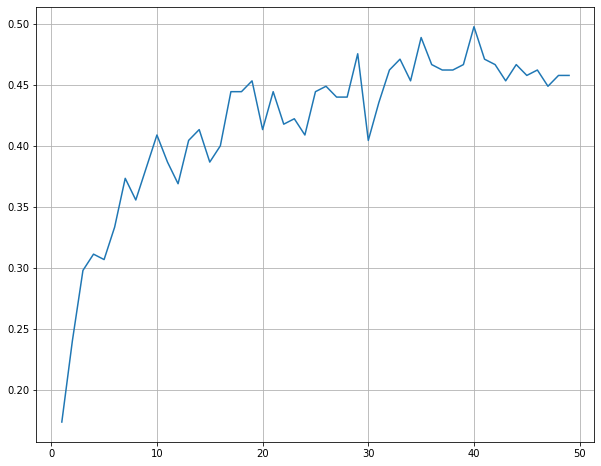

In [63]:
plt.figure(figsize=(10,8))
plt.plot(max_depth_range, accuracy)
plt.grid()

# Lets try some GridSearch

In [125]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators=[100, 400, 600, 800, 1000]
max_features=["auto", "sqrt", "log2"]
max_depth=[5,15,20,30,40]
min_samples_leaf=[1,2,5,10]
min_samples_split=[2,4,8,12]

params_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_leaf": min_samples_leaf,
    "min_samples_split": min_samples_split
}

In [128]:
RFC_GS = RandomizedSearchCV(estimator=RFC(random_state=42),
                    param_distributions=params_grid,
                    n_iter=20,
                    n_jobs=4,
                    cv=5,
                    verbose=2,
                    random_state=40
)
RFC_GS.fit(X_train, Y_train)
print("Best params:", RFC_GS.best_params_)
print("Best score:", RFC_GS.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.1min finished
Best params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30}
Best score: 0.5955555555555555


In [129]:
Y_pred = RFC_GS.predict(X_valid)
score = accuracy_score(Y_valid, Y_pred)
print(f"number of validation samples: {X_valid.shape[0]}")
print(f"accuracy: {score*100:.2f}% --> {accuracy_score(Y_valid, Y_pred, normalize=False)}")

number of validation samples: 300
accuracy: 57.67% --> 173


# PCA

Let's try to reduce the dimensionality, maybe we can get a better model that way --> PCA

In [7]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_lrn, Y_lrn, test_size=.3)

In [8]:
print("Number of instances:", X_train.shape[0])
num_feats= X_train.shape[1]
print("Number of features:", num_feats)
X_train

Number of instances: 525
Number of features: 10000


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V9991,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000
264,0.208221,-0.122133,-0.518430,1.162266,-0.969191,-0.935059,1.823759,0.166034,-0.446508,-0.681628,...,-0.384867,-0.358025,-0.397250,-0.323400,-0.394041,-0.450704,-0.430273,-0.390662,-0.462312,-0.375244
565,0.383295,2.470308,0.075646,0.386963,1.500086,1.189003,1.321991,-0.264849,1.925170,1.442559,...,-0.384867,-0.358025,-0.397250,-0.323400,-0.394041,-0.450704,-0.430273,-0.390662,-0.462312,-0.375244
441,1.083591,1.318112,0.669722,0.903832,-0.351872,1.189003,-0.685080,-0.264849,-0.920843,-0.327597,...,-0.384867,-0.358025,-0.397250,-0.323400,-0.394041,-0.450704,-0.430273,1.748000,-0.462312,-0.375244
477,-1.017296,-0.410182,-1.112506,0.128528,-1.586510,1.189003,-0.434196,-1.557498,0.502163,-0.327597,...,-0.384867,-0.358025,-0.397250,-0.323400,-0.394041,-0.450704,-0.430273,-0.390662,1.553584,-0.375244
195,0.733443,-0.410182,-0.221392,-0.646775,-1.277851,-0.227039,0.569339,-1.126615,0.027828,0.026434,...,1.442034,-0.358025,-0.397250,-0.323400,-0.394041,-0.450704,-0.430273,-0.390662,-0.462312,-0.375244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,-1.892666,0.742014,0.075646,-0.646775,-1.277851,-0.935059,1.823759,-1.557498,-0.920843,-0.327597,...,-0.384867,-0.358025,-0.397250,-0.323400,-0.394041,-0.450704,-0.430273,-0.390662,-0.462312,-0.375244
193,0.383295,2.182259,-0.221392,-1.422079,0.265447,-0.935059,0.820223,-0.695732,0.976499,-1.035659,...,-0.384867,-0.358025,1.537411,3.045354,-0.394041,3.646602,1.561732,-0.390662,1.553584,-0.375244
617,0.733443,-0.986280,0.966760,-0.646775,-0.351872,0.126972,0.569339,-1.126615,-0.446508,2.150621,...,-0.384867,-0.358025,1.537411,1.360977,-0.394041,-0.450704,-0.430273,1.748000,-0.462312,-0.375244
343,0.558369,-0.122133,0.075646,-0.388341,1.191426,0.480982,-0.685080,0.596917,0.027828,1.442559,...,-0.384867,-0.358025,-0.397250,-0.323400,1.365069,1.597949,-0.430273,-0.390662,-0.462312,-0.375244


In [51]:
from sklearn.decomposition import PCA

pcas = [PCA(n_components=n) for n in [10, 25, 100, 200, 225]]
pcas_objs = [pca.fit(X_train.values) for pca in pcas]
pcas = [pca.transform(X_train.values) for pca in pcas_objs]
#PCA(copy=True, iterated_power='auto', n_components=2, random_state=None, svd_solver='auto', tol=0.0, whiten=False)
for pca in pcas:
    print(pca)
#pcas[0].shape

[[  3.43031832 -11.02916433 -10.93644191 ...   8.60619006  -1.60762178
   -5.08292838]
 [-17.70724146   4.98351004   5.31304765 ...   6.27694436 -19.39977635
  -32.36025976]
 [ -9.90189988 -12.24126874   4.47293615 ...  -5.02400454   0.85935305
    7.20458717]
 ...
 [ -0.21937413  16.45736067   6.95456505 ...   4.33777165 -13.67547033
    3.37992258]
 [ -6.68354154  12.77948213   9.18344174 ...  -6.25308349  -5.59248949
   12.92406473]
 [-14.57262466 -15.52561783   8.50130432 ...  -3.46292295   1.51275031
   -4.97226477]]
[[  3.43008764 -11.02642128 -10.9610951  ...   1.52688707  -3.75835742
    4.559674  ]
 [-17.70758452   4.98147928   5.70882445 ...  -3.82346076 -10.00935104
   -6.40030536]
 [ -9.90198953 -12.24352585   4.57060409 ...  -4.81813595   5.4501248
    5.45628198]
 ...
 [ -0.21929722  16.45566635   6.98786628 ...   2.61760081   3.10750442
    0.72737129]
 [ -6.68294033  12.78351638   9.19057933 ...  10.74951608  -4.47877612
    3.16743832]
 [-14.57248686 -15.52820414   8.4

In [52]:
finalDfs = [pd.DataFrame(data=pca, columns=[f"pc{i}" for i in range(1,1+pca.shape[1])]) for pca in pcas]

In [53]:
from sklearn.ensemble import RandomForestClassifier as RFC

RF_PCAs = [RFC(n_jobs=-1, n_estimators=500, max_features="auto", bootstrap=True, oob_score=True) for _ in pcas]
RF_PCAs[0]

RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True)

In [160]:
finalDfs[-2]

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc91,pc92,pc93,pc94,pc95,pc96,pc97,pc98,pc99,pc100
0,16.511131,-26.715407,7.838281,12.940739,6.049301,-4.361738,-5.769944,-9.433231,4.295321,-9.539890,...,-5.787394,-1.986740,-4.590370,-1.825168,3.783025,2.885989,0.063593,6.822076,-4.211299,-2.367464
1,5.438262,-9.955346,-8.356810,8.141005,-6.591115,-10.695282,16.302858,-0.145316,0.326995,7.353725,...,1.837024,2.903904,0.126196,-4.095129,4.314417,3.622759,0.664839,-1.429220,-3.553942,-0.147547
2,28.339026,28.685332,-15.662330,-4.678663,-8.287392,-5.583929,-12.435026,-0.034747,-7.322805,-12.031544,...,3.718606,-6.603676,-3.891210,0.088692,2.024708,1.182754,-4.758555,6.244366,3.613868,-3.222606
3,44.665211,17.579839,-18.115547,6.361071,1.131066,-6.218566,-25.498921,17.828425,6.611678,2.780941,...,3.636660,1.073634,2.030238,-2.590020,-3.552134,1.859899,-2.272525,-0.664115,-3.020105,6.059327
4,-82.941278,-10.768527,-17.960391,8.959819,-4.222943,7.725968,-1.075946,10.384305,20.615799,-4.527702,...,3.155064,-3.662313,0.789542,3.876188,4.620672,-2.447962,-4.634747,1.933976,-10.253075,-5.320339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,50.868923,26.250521,9.118975,2.606305,-20.653768,-8.584164,-10.588731,-17.103068,-12.675352,-11.609654,...,-1.712956,-2.124834,3.838165,0.305233,1.103200,-0.823556,-0.809239,0.421367,8.138387,-2.764782
446,250.563147,-3.637493,9.094398,5.098351,0.577620,6.763806,-4.092140,0.434605,-0.778162,-5.914144,...,-1.482152,0.132980,-0.554026,1.829123,0.905477,1.737027,0.025944,2.211530,0.445932,0.628753
447,-79.290698,41.484774,-29.935563,2.878177,-8.339005,10.182994,11.381218,-24.395054,-5.752277,11.752378,...,-5.954199,2.607926,-4.492053,0.982648,-7.818147,-1.135596,-2.743912,1.518003,-2.633035,-5.682491
448,43.463790,0.770065,-10.147937,3.858490,-17.105523,-10.306441,11.203982,24.482049,2.786993,1.824428,...,1.069280,1.637443,-0.467356,-2.863164,-1.713703,-3.485192,-7.518907,-1.735287,-0.889591,7.868883


In [58]:
pcas_valid = [pca.transform(X_valid.values) for pca in pcas_objs]
valid_Dfs = [pd.DataFrame(data=pca, columns=[f"pc{i}" for i in range(1,1+pca.shape[1])]) for pca in pcas_valid]

In [54]:
for df, rf in zip(finalDfs, RF_PCAs):
    print(rf)
    print(f"num features: {df.shape[1]}")
    rf.fit(df, Y_train)
    print(f"oob score: {rf.oob_score_}")
    print("-"*40)

RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True)
num features: 10
oob score: 0.3028571428571429
----------------------------------------
RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True)
num features: 25
oob score: 0.4095238095238095
----------------------------------------
RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True)
num features: 100
oob score: 0.41904761904761906
----------------------------------------
RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True)
num features: 200
oob score: 0.36952380952380953
----------------------------------------
RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True)
num features: 225
oob score: 0.3504761904761905
----------------------------------------


In [59]:
for df, rfc in zip(valid_Dfs, RF_PCAs):
    Y_pred = rfc.predict(df)
    score = accuracy_score(Y_valid, Y_pred)
    print(f"number of validation samples: {df.shape[0]}")
    print(f"accuracy: {score*100:.2f}% --> {accuracy_score(Y_valid, Y_pred, normalize=False)}")

number of validation samples: 225
accuracy: 5.78% --> 13
number of validation samples: 225
accuracy: 1.78% --> 4
number of validation samples: 225
accuracy: 5.33% --> 12
number of validation samples: 225
accuracy: 5.33% --> 12
number of validation samples: 225
accuracy: 5.33% --> 12


# End of PCA

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(range(1,51), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error rate vs k-Value')
plt.xlabel('k-Value')
plt.ylabel('Error rate')

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(1, 51)}

knn = KNeighborsClassifier()

model = GridSearchCV(knn, params, cv=10)
model.fit(X_train, y_train)
print("Best k-Value is: ", model.best_params_['n_neighbors'])

In [ ]:
pred = model.predict(X_test)

In [ ]:
solution_data = list(zip(list(range(750,1500)), pred))

In [ ]:
solution_table = pd.DataFrame(solution_data, columns=['ID', 'Class'])
solution_table.head()